# Predict municipality

In [1]:
import pandas
import MySQLdb
import numpy
import json
import re

db = MySQLdb.connect(user='root', passwd='Nmmxhjgt1@', db='stimmenfryslan', charset='utf8')

from matplotlib import pyplot
import folium
from IPython.display import display
from shapely.geometry import Polygon, MultiPolygon, shape, Point
from jupyter_progressbar import ProgressBar
from collections import defaultdict
from ipy_table import make_table

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

from confusion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

%matplotlib notebook
from matplotlib import pyplot

import autosklearn.classification
from tpot import TPOTClassifier

/home/herbert/.virtualenvs/stimmenfryslan/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Borders of Frysian municipalities

with open('Friesland_AL8.GeoJson') as f:
    gemeentes = json.load(f)

In [3]:
shapes = [shape(feature['geometry']) for feature in gemeentes['features']]
gemeente_names = [feature['properties']['name'] for feature in gemeentes['features']]

def get_gemeente(point):
    for i, shape in enumerate(shapes):
        if shape.contains(point):
            return i
    return -1

In [4]:
# Answers to how participants state a word should be pronounces.

answers = pandas.read_sql('''
SELECT prediction_quiz_id, user_lat, user_lng, question_text, answer_text
FROM       core_surveyresult as survey
INNER JOIN core_predictionquizresult as result ON survey.id = result.survey_result_id
INNER JOIN core_predictionquizresultquestionanswer as answer
    ON result.id = answer.prediction_quiz_id
''', db)

# Takes approximately 2 minutes

gemeente_map = {
    (lng, lat): get_gemeente(Point(lng, lat))
    for lng, lat in set(zip(answers['user_lng'], answers['user_lat']))
}

answers['gemeente'] = [
    gemeente_map[(lng, lat)]
    for lat, lng in zip(answers['user_lat'], answers['user_lng'])
]

answers['pronunciation'] = [
    s[s.find('(')+1:-1]
    for s in answers['answer_text']
]

answers['word'] = [
    re.sub(r'\(.*\)', '', s).replace('"', '').strip()
    for s in answers['question_text']
]

answers['input'] = [
    pronunciation + '_' + word
    for pronunciation, word in zip(answers['pronunciation'], answers['word'])
]

In [5]:
dataset = answers[['prediction_quiz_id', 'gemeente', 'input']].groupby(
    ['prediction_quiz_id', 'gemeente']
).aggregate('+'.join)

dataset.reset_index(inplace = True)
dataset = dataset[dataset['gemeente'] >= 0]

In [6]:
characters = list({x for x in dataset['input'] for x in x})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset['input'], dataset['gemeente'])

In [9]:
tfidf = TfidfVectorizer(analyzer='char')
svc = SVC()

model = Pipeline(steps=[('tfidf', tfidf), ('svm', svc)])

parameters = {
    'tfidf__ngram_range': [(1,5), (1,2), (1,6), (1,10), (1,3)],
    'tfidf__max_features': [20],
    'svm__C': stats.uniform(0, 100.),
    'svm__kernel': ['linear', 'rbf'],
    'svm__degree': stats.randint(0, 5),
    'svm__gamma': stats.uniform(0, 10.),
    'svm__coef0': stats.uniform(0, 10.),
    'svm__shrinking': [True],
    'svm__probability': [False],
    'svm__cache_size': [2000],
    'svm__class_weight': [None],
    'svm__verbose': [False],
    'svm__max_iter': [-1],
    'svm__random_state': [None],
}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(model, param_distributions=parameters, n_iter=n_iter_search, n_jobs=8)
random_search.fit(X_train, y_train)

/home/herbert/.virtualenvs/stimmenfryslan/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=8,
          param_distributions={'svm__cache_size': [2000], 'svm__coef0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fef8dfbea90>, 'svm__kernel': ['linear', 'rbf'], 'tfidf__max_features': [20], 'svm__class_weight': [None], 'tfidf__ngram_range': [(1, 5), (1, 2), (1, 6), (1, 10), (1, 3)], 'svm__shr...t 0x7fef8dfbe6d8>, 'svm__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fef8dfd5240>},
          pre_dispatch='2

In [12]:
y_pred = random_search.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.38      0.53      0.44        91
          1       0.50      0.50      0.50         2
          2       0.35      0.22      0.27        54
          3       0.32      0.18      0.23        51
          4       0.38      0.59      0.46        46
          5       0.23      0.14      0.17        22
          6       0.00      0.00      0.00         2
          7       0.33      0.19      0.24        31
          8       1.00      0.03      0.06        35
          9       0.21      0.29      0.25        68
         10       0.00      0.00      0.00         4
         11       0.28      0.14      0.18        37
         12       0.00      0.00      0.00         4
         13       0.23      0.26      0.24        35
         14       0.42      0.72      0.53       134
         16       0.36      0.25      0.30        52
         18       0.48      0.19      0.27        73
         19       0.00      0.00      0.00   

/home/herbert/.virtualenvs/stimmenfryslan/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
(y_pred == y_test).mean()

0.3557951482479784

In [16]:
existing_gemeente_names = [
    gemeente_names[i] if i >= 0 else 'Onbekend'
    for i in sorted(set(y_test)) # dataset['gemeente']))
]

In [94]:
y_pred = model.predict(X_test)

In [95]:
(y_pred == y_test).mean()

0.37870619946091644

Confusion matrix, without normalization


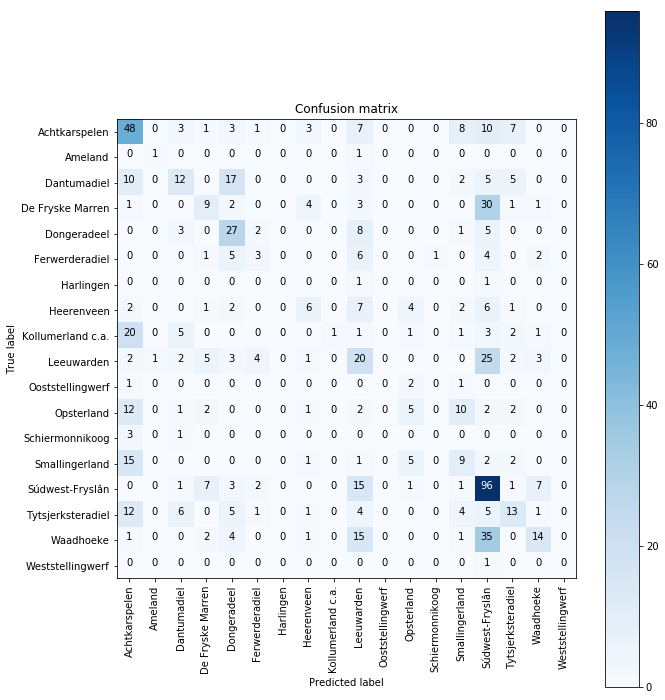

In [17]:
pyplot.rcParams['figure.figsize'] = (9.8, 10)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=existing_gemeente_names)
pyplot.tight_layout()

In [86]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.36      0.37      0.36        84
          1       0.00      0.00      0.00         1
          2       0.24      0.18      0.21        45
          3       0.51      0.55      0.53        51
          4       0.43      0.33      0.38        57
          5       0.19      0.15      0.16        34
          6       0.00      0.00      0.00         2
          7       0.21      0.22      0.22        32
          8       0.05      0.06      0.05        33
          9       0.23      0.24      0.23        72
         10       0.00      0.00      0.00         3
         11       0.20      0.15      0.17        40
         12       0.00      0.00      0.00         3
         13       0.24      0.38      0.29        40
         14       0.53      0.48      0.50       124
         16       0.20      0.19      0.20        47
         18       0.41      0.44      0.43        72
         19       0.00      0.00      0.00   

In [19]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.optimizers import Adam

numpy.random.seed(7)

Using TensorFlow backend.


In [20]:
char_to_num = {c: i for i, c in enumerate(characters)}

In [40]:
dataset['input'][0]

'gɔ:n_gegaan+jun_avond+hø:l_heel+dɑɪ_dag+bɛi_bij+spɾɵts_sprak+eɪx_oog+jɛɾms_armen+tsi:s_kaas+dwɑɾkə_deurtje+sɪəɾə_koken+bwɑst_borst+fisk_vis+snɵən_zaterdag+tɾɑɪn_trein+ɡɪəl_geel+tosk_tand+sɛt_gezet+blɛ:t_blad'

In [34]:
[c.count('_') for c in dataset['input']]

[19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,


In [21]:
X = sequence.pad_sequences([[char_to_num[c] for c in c] for c in dataset['input']], value=len(char_to_num))

y = numpy.array(dataset['gemeente'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
# from sklearn.preprocessing import OneHotEncoder
# n_values = max(X.ravel()) + 1
# enc = OneHotEncoder(n_values=n_values)
# X_ = enc.fit_transform(X)
# X_ = numpy.array(X_.todense()).reshape(X.shape + (n_values, ))

In [23]:
X[:, 20:]

array([[31, 39, 31, ..., 37, 12, 48],
       [36, 15, 27, ...,  5,  5, 31],
       [26, 34,  6, ...,  5, 13, 48],
       ...,
       [ 3, 31, 19, ..., 39, 39, 37],
       [48,  3, 36, ..., 27, 36, 41],
       [ 0, 12, 41, ..., 43, 24, 26]], dtype=int32)

In [28]:
lstm = Sequential()
lstm.add(Embedding(X.max() + 1, 512, input_length=X.shape[1]))
lstm.add(LSTM(16))
lstm.add(Dense(max(y) + 1))

In [43]:
optimizer = Adam(lr=0.0001)

lstm.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [44]:
lstm.fit(X_train, y_train, batch_size=512, epochs=100, validation_split=0.1)# , validation_data=(X_test, y_test), verbose=2)

Train on 2002 samples, validate on 223 samples
Epoch 1/100
2002/2002 [==============================] - 3s 1ms/step - loss: 2.6484 - acc: 0.1518 - val_loss: 2.7888 - val_acc: 0.1659
Epoch 2/100
2002/2002 [==============================] - 2s 1ms/step - loss: 2.6440 - acc: 0.1548 - val_loss: 2.7866 - val_acc: 0.1749
Epoch 3/100
2002/2002 [==============================] - 2s 1ms/step - loss: 2.6419 - acc: 0.1608 - val_loss: 2.7870 - val_acc: 0.1749
Epoch 4/100
2002/2002 [==============================] - 2s 1ms/step - loss: 2.6396 - acc: 0.1603 - val_loss: 2.7872 - val_acc: 0.1749
Epoch 5/100
2002/2002 [==============================] - 2s 1ms/step - loss: 2.6373 - acc: 0.1603 - val_loss: 2.7858 - val_acc: 0.1749
Epoch 6/100
2002/2002 [==============================] - 2s 789us/step - loss: 2.6356 - acc: 0.1598 - val_loss: 2.7876 - val_acc: 0.1749
Epoch 7/100
2002/2002 [==============================] - 2s 792us/step - loss: 2.6343 - acc: 0.1588 - val_loss: 2.7876 - val_acc: 0.1749
Epoc